# Project 1: Image Classification and Regression
# MVA - CentraleSupelec

## ZHOU Julien  

The goal of this project is to learn how to implement simple image classification and regression in Keras.  
This work has been produced for the Deep Learning course taught at CentraleSupélec.  
The course materials can be found here: https://www.labri.fr/perso/vlepetit/deep_learning_mva.php

# 2) Getting started
The following part contains a framework of functions provided for the project.  
These functions are re-used in the following, their overall role is to generate random images of rectangles, disks and triangles, with or without noise, and located randomly or centered in the image:

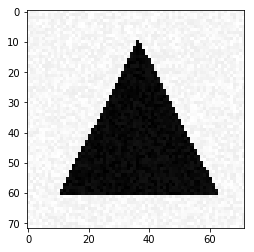

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3) Simple Classification
We generate a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images.

In [2]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


D:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


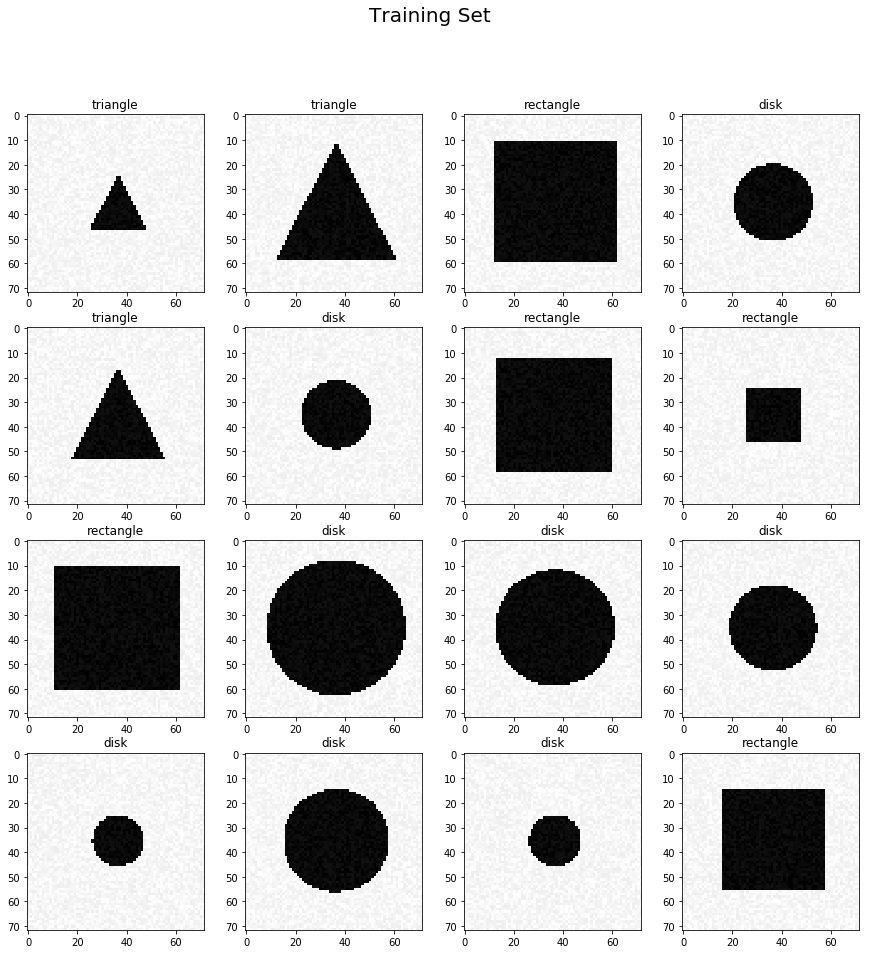

In [4]:
plt.figure(figsize=(15,15))
plt.suptitle("Training Set", fontsize=20)
for i in range(1,17):
    plt.subplot(4,4,i)
    if Y_train[i][0] == 1.:
        plt.title("rectangle")
    if Y_train[i][1] == 1.:
        plt.title("disk")
    if Y_train[i][2] == 1.:
        plt.title("triangle")
    plt.imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We first build and train a linear classifier to classify a image into one of the three possible categories.

It correspond to a network with only one layer, which is actvated by a softmax function.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],)))
model.add(Activation('softmax'))

We first train it with a stochastic gradient descent.  
The loss function used to train the model is a categorical crossentropy as we are in a classification problem.  
The metric used to evaluate the model is the accuracy.  
We use a validation split a 0.3.

In [6]:
from keras.optimizers import SGD
sgd = SGD(lr=0.003)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


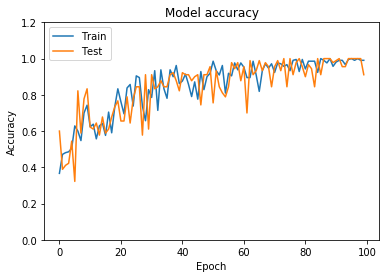

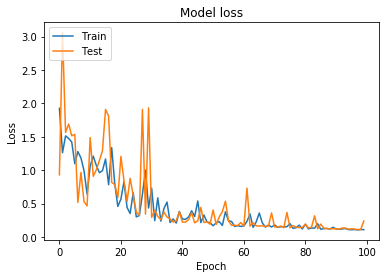

In [7]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1.2)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model model is trained on 100 epochs and converges toward a rather accurate classifier on the training and the validation sets.

We then try an Adam optimizer on the same model.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


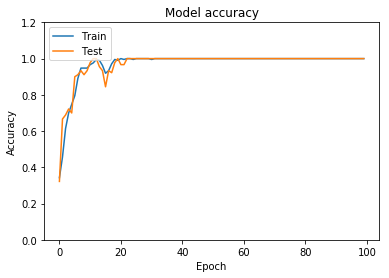

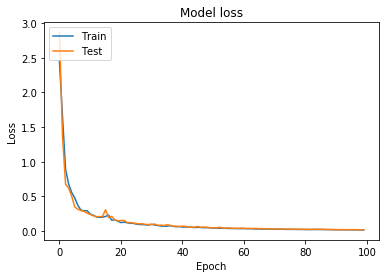

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1.2)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The Adam optimizer works a lot faster and the paramters trained stay at the optimum.

Let's test the model on a test set.

In [10]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, False)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [11]:
model.metrics_names

['loss', 'acc']

In [12]:
model.evaluate(x=X_test, y=Y_test)

300/300 [==============================] - 0s 70us/step


[0.01739466627438863, 1.0]

The trained model works well with an accuray close to 1.

In [13]:
Y_predict=model.predict(X_test)

In [14]:
for i in range(300):
    category = Y_predict[i].argmax()
    if category == 0:
        Y_predict[i][0] = 1.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 0.
    if category == 1:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 1.
        Y_predict[i][2] = 0.
    if category == 2:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 1.

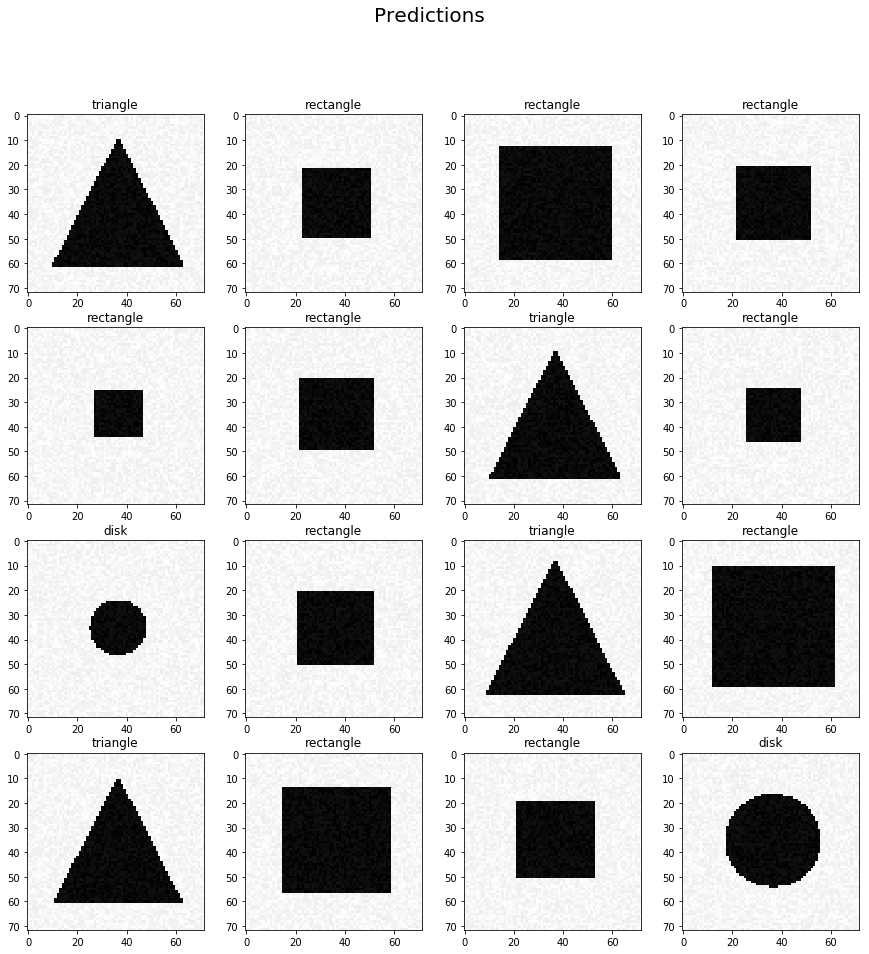

In [15]:
plt.figure(figsize=(15,15))
plt.suptitle("Predictions", fontsize=20)
for i in range(1,17):
    plt.subplot(4,4,i)
    if Y_predict[i][0] == 1.:
        plt.title("rectangle")
    if Y_predict[i][1] == 1.:
        plt.title("disk")
    if Y_predict[i][2] == 1.:
        plt.title("triangle")
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In conclusion, we have implemented a simple linear classifier on our data, which is elaborate enough to accurately predict the classes of the figures.
We have tested a Stochastic Gradient Descent and an Adam Optimizer on our model, the latter working better.

# 4) Visualisation of the Solution

We would like to visualize the weights of the linear classifier.

In [16]:
model_weights = model.get_weights()

Text(0.5,1,'Weight for rectangle')

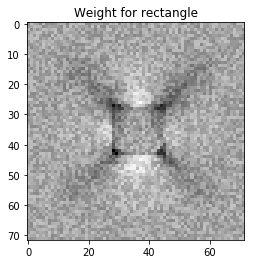

In [17]:
rectangle_weight = model_weights[0][:,0]
plt.imshow(rectangle_weight.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Weight for rectangle")

Text(0.5,1,'Weight for disk')

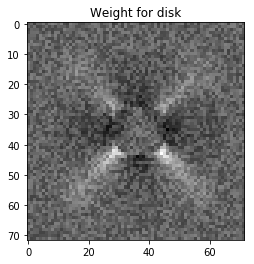

In [18]:
disk_weight = model_weights[0][:,1]
plt.imshow(disk_weight.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Weight for disk")

Text(0.5,1,'Weight for triangle')

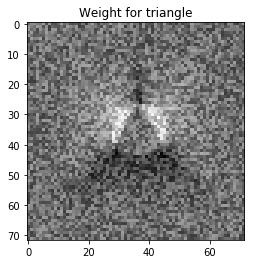

In [19]:
triangle_weight = model_weights[0][:,2]
plt.imshow(triangle_weight.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Weight for triangle")

As we can see, the shape of the weights are close to the actual shapes that we are trying to classify.  
In fact, they are trying to recognize particular features of the shapes that differentiate them.  
For the rectagle, the weights are concentrated on the 4 vertices.
For the disk, the weights look for images with something at the top, the bottom, on the left and on the rights.  
For the trianlge, the weights are looking for images with one top centerd corner and two corners at the bottom.

# 5) A More Difficult Classification Problem

We now allow the shapes to move withing the image and change dimensions. We generate a new training set:

In [20]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
    
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


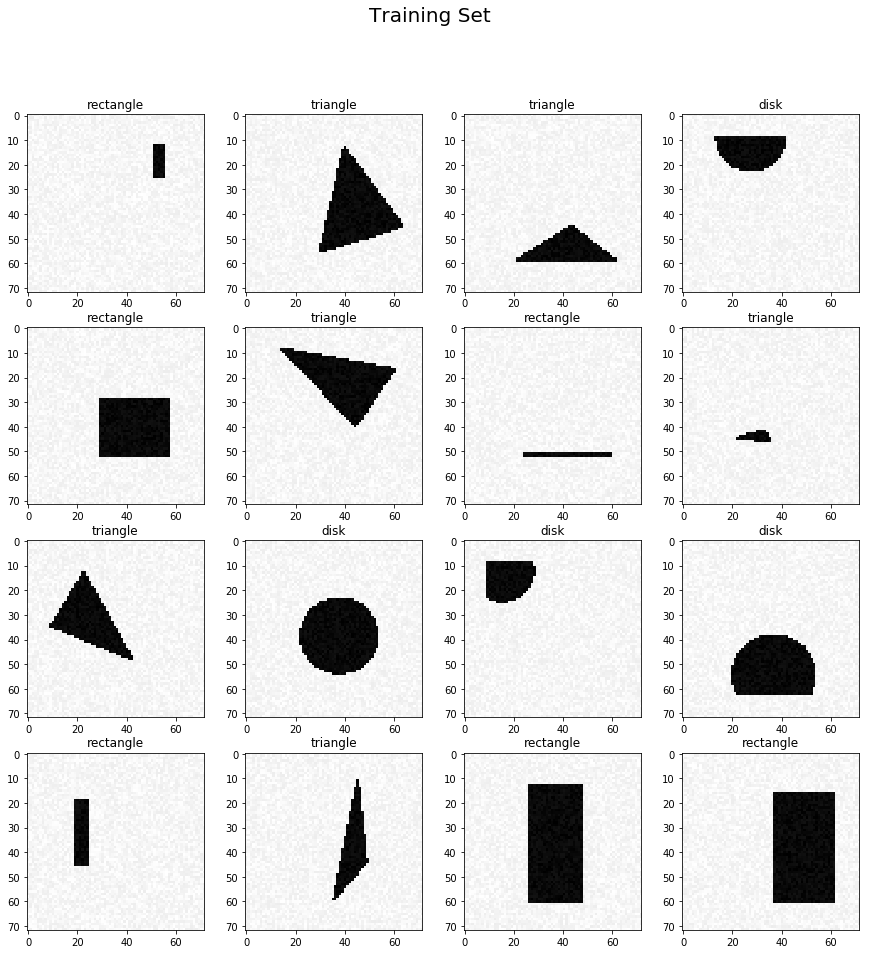

In [21]:
plt.figure(figsize=(15,15))
plt.suptitle("Training Set", fontsize=20)
for i in range(1,17):
    plt.subplot(4,4,i)
    if Y_train[i][0] == 1.:
        plt.title("rectangle")
    if Y_train[i][1] == 1.:
        plt.title("disk")
    if Y_train[i][2] == 1.:
        plt.title("triangle")
    plt.imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We retrain our linear classifier on this new training set, with the Adam optimizer.

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


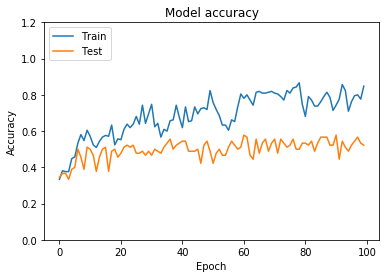

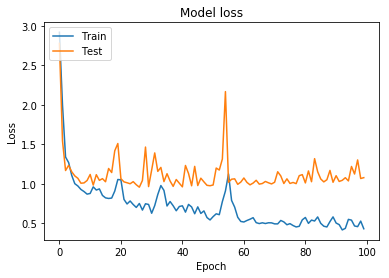

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1.2)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

This time, the model works less. The accuracy on the training set does not increase a lot. The model is not elaborate enough. We have added variations for the shapes but we have not enough paramters in the model.

In [24]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

[X_test, Y_test] = generate_test_set_classification()
model.evaluate(x=X_test, y=Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 70us/step


[1.0078192575772604, 0.553333332935969]

This time, the accuracy remains lower than 60% and the loss function remains higher. It is still better than a random classifier (1/3 accuracy) but not really statisfying.

In [25]:
Y_predict=model.predict(X_test)

for i in range(300):
    category = Y_predict[i].argmax()
    if category == 0:
        Y_predict[i][0] = 1.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 0.
    if category == 1:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 1.
        Y_predict[i][2] = 0.
    if category == 2:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 1.

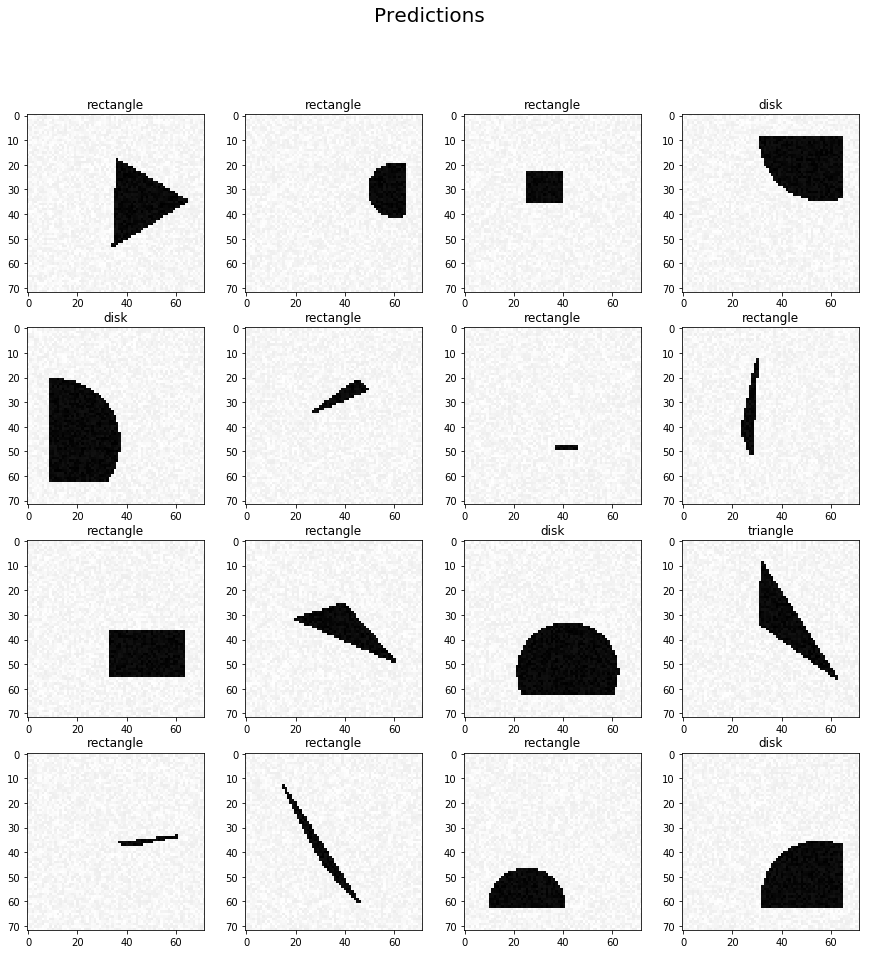

In [26]:
plt.figure(figsize=(15,15))
plt.suptitle("Predictions", fontsize=20)
for i in range(1,17):
    plt.subplot(4,4,i)
    if Y_predict[i][0] == 1.:
        plt.title("rectangle")
    if Y_predict[i][1] == 1.:
        plt.title("disk")
    if Y_predict[i][2] == 1.:
        plt.title("triangle")
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We now train a convolutional deep network on a dataset.

In [27]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

X_train = X_train.reshape(X_train.shape[0],72,72,1)

X_test = X_test.reshape(X_test.shape[0],72,72,1)

model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


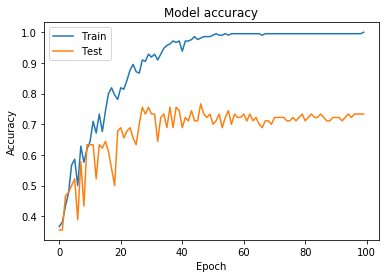

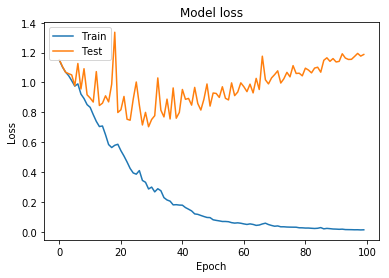

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The training accuracy reach 1 but the model does not generalize well. In fact, our model has more paramters and can fit the training set well, but it does not apply to a more general set of data.  
Therefore, we increase the training set.

In [31]:
[X_train, Y_train] = generate_dataset_classification(2000, 20, True)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

X_train = X_train.reshape(X_train.shape[0],72,72,1)

X_test = X_test.reshape(X_test.shape[0],72,72,1)

model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


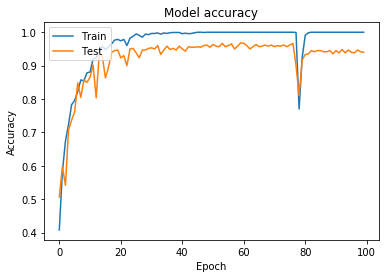

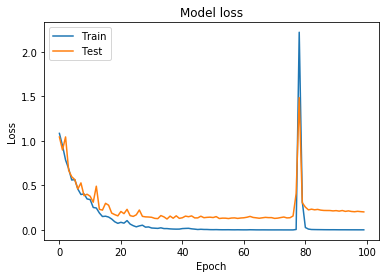

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(X_test.shape[0],72,72,1)
model.evaluate(x=X_test, y=Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 1ms/step


[0.23400724291801453, 0.933333334128062]

With enough training data and a model elaborate enough to take account for the increased variability, the accuracy on a test set can reach more than 90%.

In [36]:
Y_predict=model.predict(X_test)

for i in range(300):
    category = Y_predict[i].argmax()
    if category == 0:
        Y_predict[i][0] = 1.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 0.
    if category == 1:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 1.
        Y_predict[i][2] = 0.
    if category == 2:
        Y_predict[i][0] = 0.
        Y_predict[i][1] = 0.
        Y_predict[i][2] = 1.

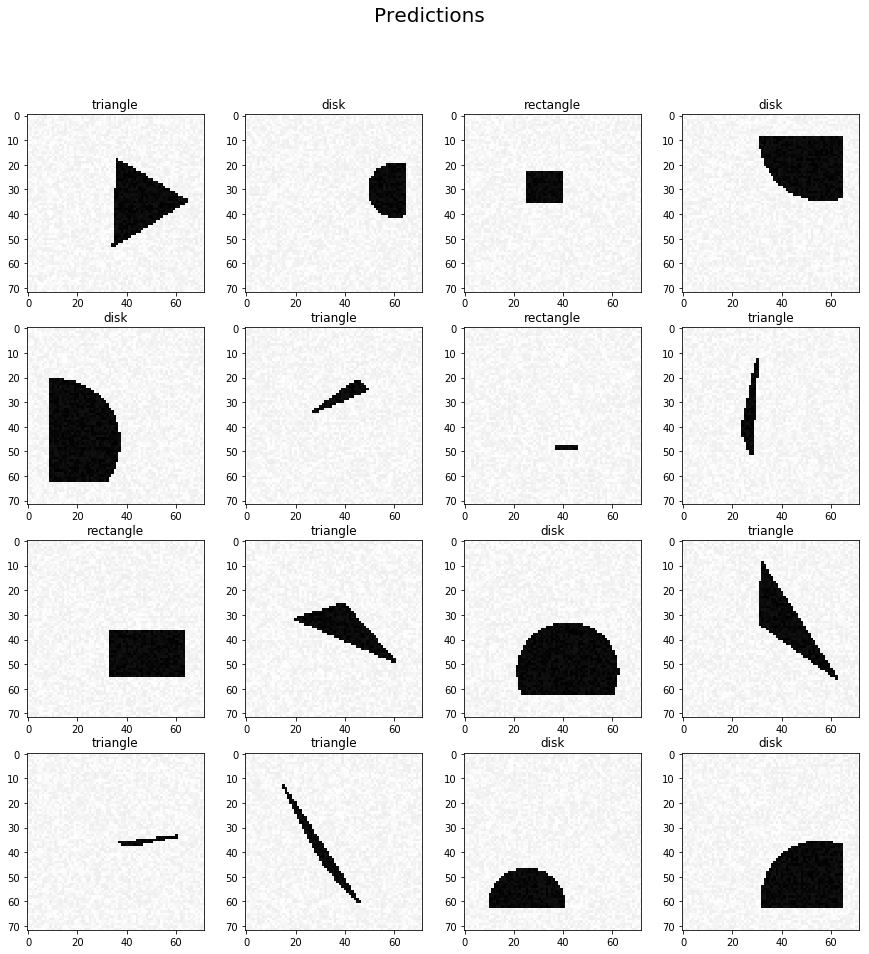

In [37]:
plt.figure(figsize=(15,15))
plt.suptitle("Predictions", fontsize=20)
for i in range(1,17):
    plt.subplot(4,4,i)
    if Y_predict[i][0] == 1.:
        plt.title("rectangle")
    if Y_predict[i][1] == 1.:
        plt.title("disk")
    if Y_predict[i][2] == 1.:
        plt.title("triangle")
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 6) A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle.   
We first generate a training set.

In [38]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [39]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


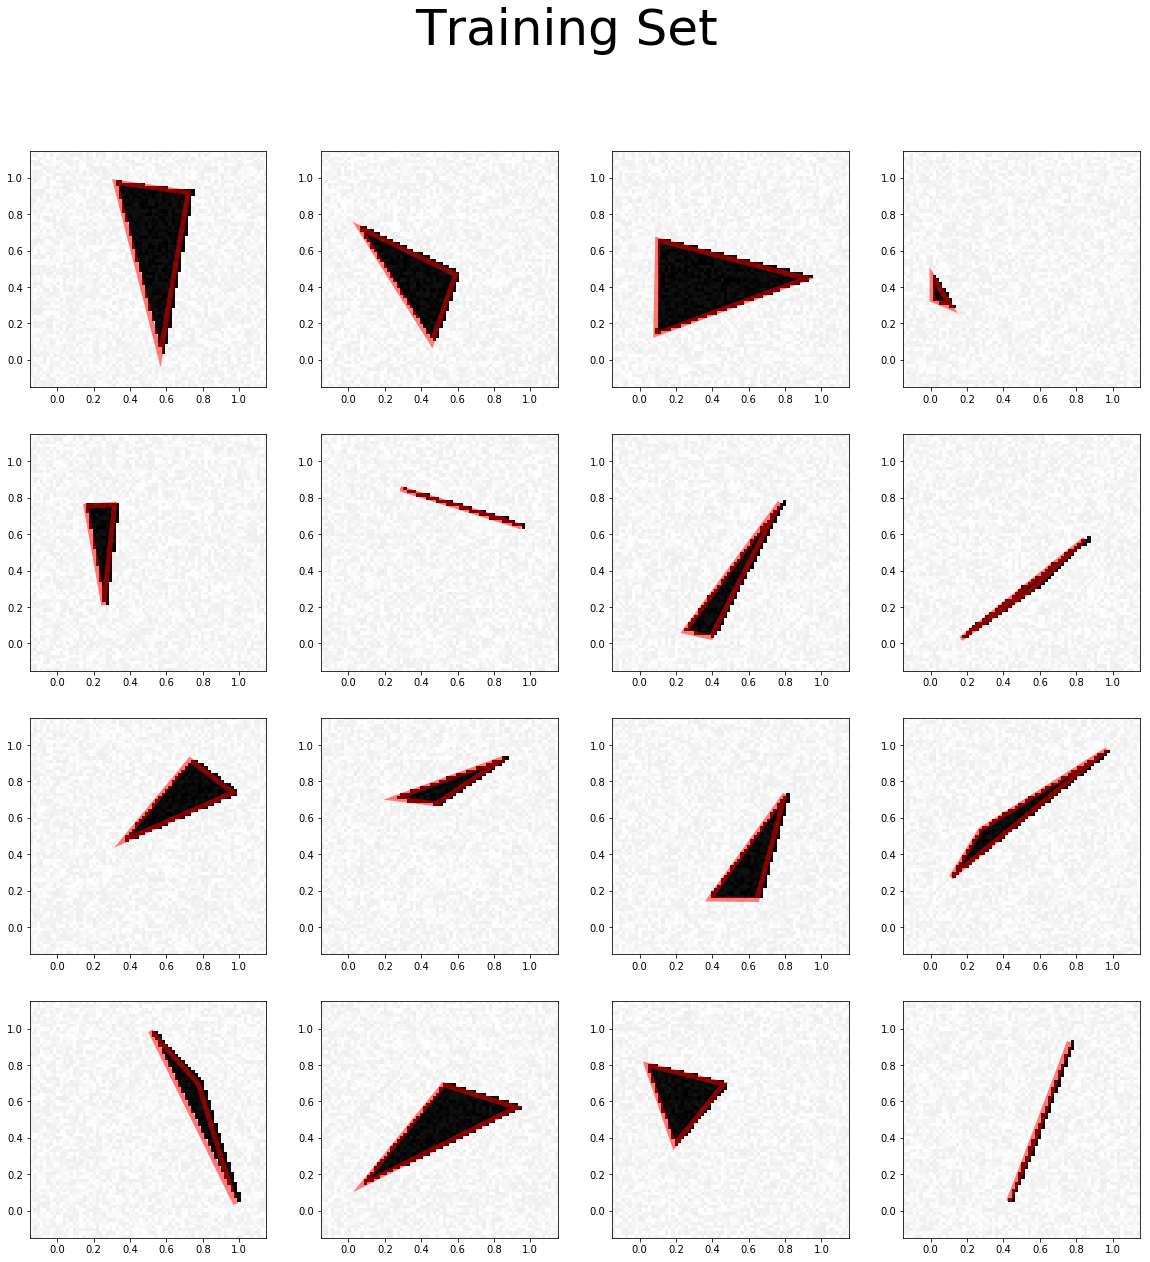

In [40]:
fig, ax = plt.subplots(4,4, figsize=(20, 20))
plt.suptitle("Training Set", fontsize=50)
for i in range(0,16):
    x = X_train[i]
    y = Y_train[i]
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax[i//4,i%4].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
plt.show()

We choose to sort the vertices following increasing x, and then y.

In [41]:
def v_comparator(v1, v2):
    if v1[0]<v2[0]:
        return True
    else:
        if v1[0] == v2[0]:
            return v1[1]<=v2[1]
        else:
            return False

def Y_sorting(vertices_vector):
    v1 = np.array([vertices_vector[0],vertices_vector[1]])
    v2 = np.array([vertices_vector[2],vertices_vector[3]])
    v3 = np.array([vertices_vector[4],vertices_vector[5]])
    sorted_y = np.zeros((1,6))
    if v_comparator(v1, v2):
        if v_comparator(v1,v3):
            sorted_y[0,0] = v1[0]
            sorted_y[0,1] = v1[1]
            if v_comparator(v2,v3):
                sorted_y[0,2] = v2[0]
                sorted_y[0,3] = v2[1]
                sorted_y[0,4] = v3[0]
                sorted_y[0,5] = v3[1]
            else:
                sorted_y[0,2] = v3[0]
                sorted_y[0,3] = v3[1]
                sorted_y[0,4] = v2[0]
                sorted_y[0,5] = v2[1]
        else:
            sorted_y[0,0] = v3[0]
            sorted_y[0,1] = v3[1]
            sorted_y[0,2] = v1[0]
            sorted_y[0,3] = v1[1]
            sorted_y[0,4] = v2[0]
            sorted_y[0,5] = v2[1]
    else:
        if v_comparator(v2,v3):
            sorted_y[0,0] = v2[0]
            sorted_y[0,1] = v2[1]
            if v_comparator(v1,v3):
                sorted_y[0,2] = v1[0]
                sorted_y[0,3] = v1[1]
                sorted_y[0,4] = v3[0]
                sorted_y[0,5] = v3[1]
            else:
                sorted_y[0,2] = v3[0]
                sorted_y[0,3] = v3[1]
                sorted_y[0,4] = v1[0]
                sorted_y[0,5] = v1[1]
        else:
            sorted_y[0,0] = v3[0]
            sorted_y[0,1] = v3[1]
            sorted_y[0,2] = v2[0]
            sorted_y[0,3] = v2[1]
            sorted_y[0,4] = v1[0]
            sorted_y[0,5] = v1[1]
    return sorted_y

In [42]:
def Y_set_sort(Y_set):
    n = Y_set.shape[0]
    res = np.zeros(Y_set.shape)
    for i in range(n):
        res[i] = Y_sorting(Y_set[i])
    return res

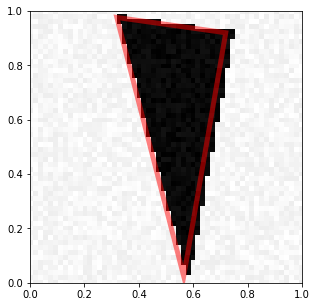

In [43]:
Y_train_norm = Y_set_sort(Y_train)
visualize_prediction(X_train[0], Y_train_norm[0])

We use here a deeper network

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

X_train = X_train.reshape(X_train.shape[0],72,72,1)

model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2,2)))
print(model.output_shape)


model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2,2)))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(50))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dropout(0.2))
model.add(Dense(6))
print(model.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 30, 30, 16)
(None, 15, 15, 16)
(None, 3600)
(None, 50)
(None, 25)
(None, 6)


The loss function that we use is the mean squared error between the predicted vertices and the ground true ones, and we use the adam optimizer.

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train_norm, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


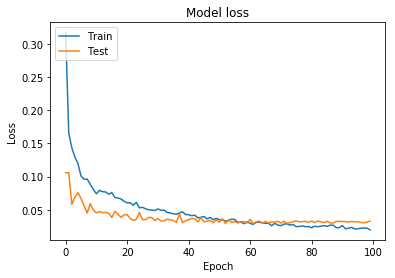

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We reach around the same errors on the training and test sets.

In [47]:
Y_train_predict=model.predict(X_train.reshape(300,72,72,1))

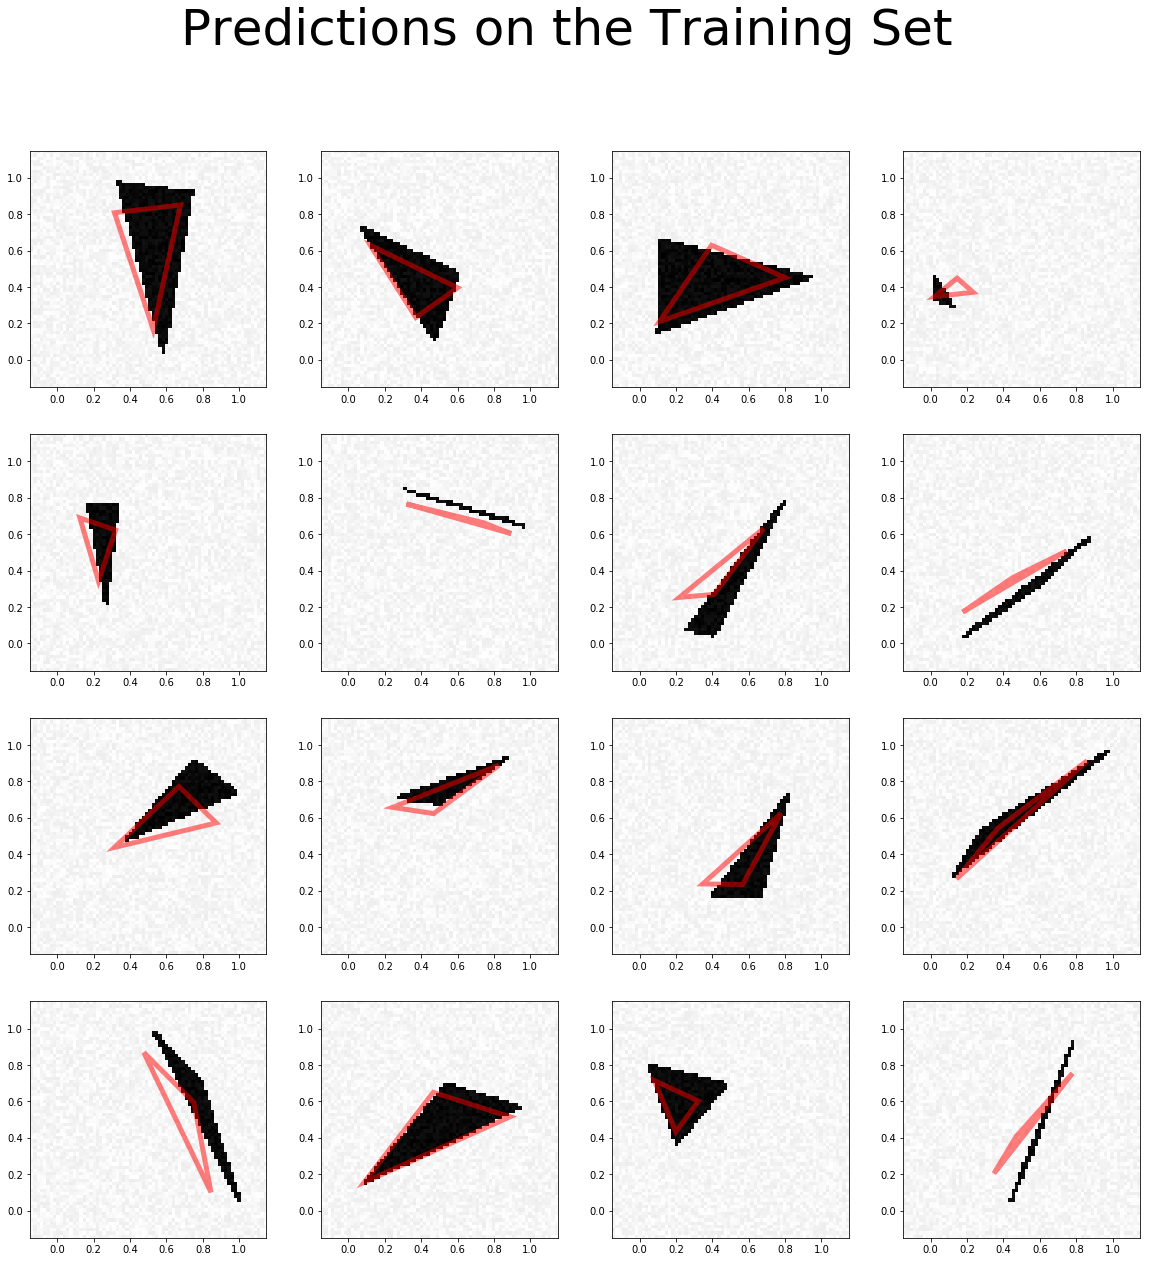

In [48]:
fig, ax = plt.subplots(4,4, figsize=(20, 20))
plt.suptitle("Predictions on the Training Set", fontsize=50)
for i in range(0,16):
    x = X_train[i]
    y = Y_train_predict[i]
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax[i//4,i%4].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
plt.show()

The predicted vertices in the training set are in the right area of the image and are sometimes accurate but not always.  
We check the results on a test set.

In [49]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

X_test, Y_test = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0],72,72,1)
Y_test_norm = Y_set_sort(Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [50]:
model.evaluate(x=X_test, y=Y_test_norm)

300/300 [==============================] - 0s 1ms/step


0.03173078551888466

In [51]:
Y_test_predict=model.predict(X_test.reshape(300,72,72,1))

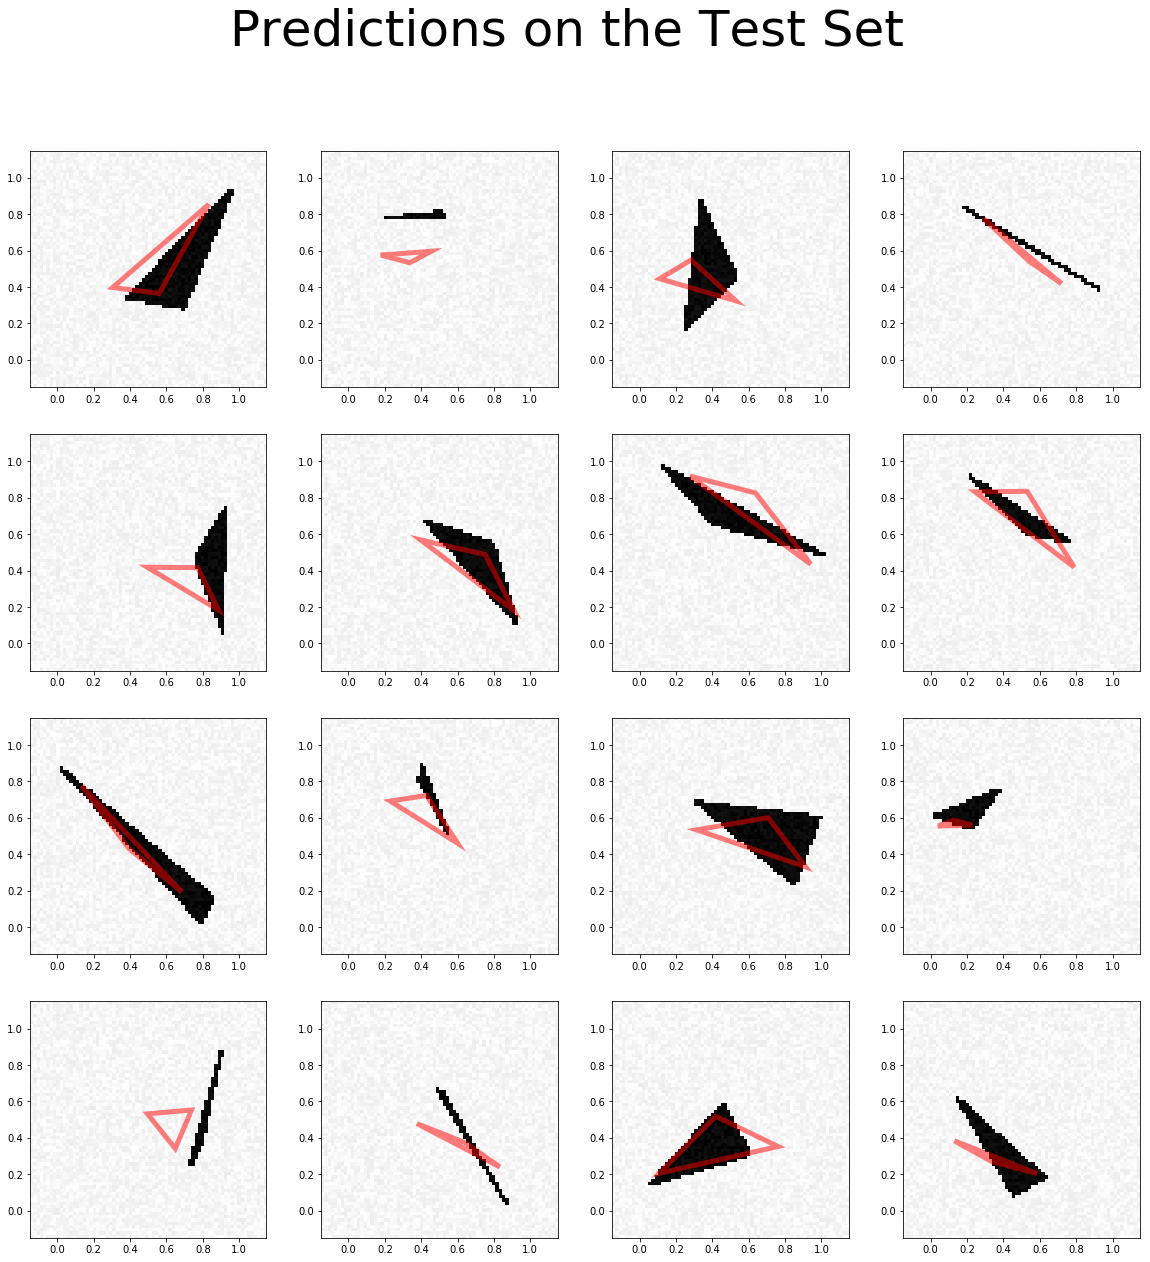

In [52]:
fig, ax = plt.subplots(4,4, figsize=(20, 20))
plt.suptitle("Predictions on the Test Set", fontsize=50)
for i in range(0,16):
    x = X_test[i]
    y = Y_test_predict[i]
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax[i//4,i%4].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
plt.show()

The predicted vertices are in the right area here as well but they are less often accurate.  
Let's try to increase the training set.

In [53]:
[X_train, Y_train] = generate_dataset_regression(1500, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490


In [54]:
Y_train_norm = Y_set_sort(Y_train)

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

X_train = X_train.reshape(X_train.shape[0],72,72,1)

model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2,2)))
print(model.output_shape)


model.add(Conv2D(16, (5,5), input_shape=(72,72,1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2,2)))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dropout(0.2))
model.add(Dense(6))
print(model.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 30, 30, 16)
(None, 15, 15, 16)
(None, 3600)
(None, 100)
(None, 50)
(None, 6)


In [56]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train_norm, epochs=100, validation_split = 0.3, batch_size=32, verbose = 0)
print('trained')

trained


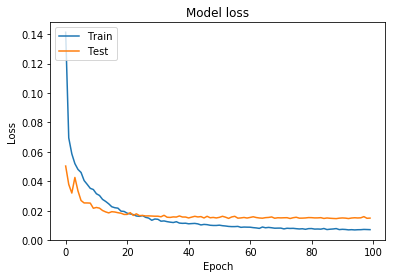

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
model.evaluate(x=X_test, y=Y_test_norm)

300/300 [==============================] - 0s 1ms/step


0.016197106937567395

The loss at the end of the training a lower than before thanks to the augmented dataset.

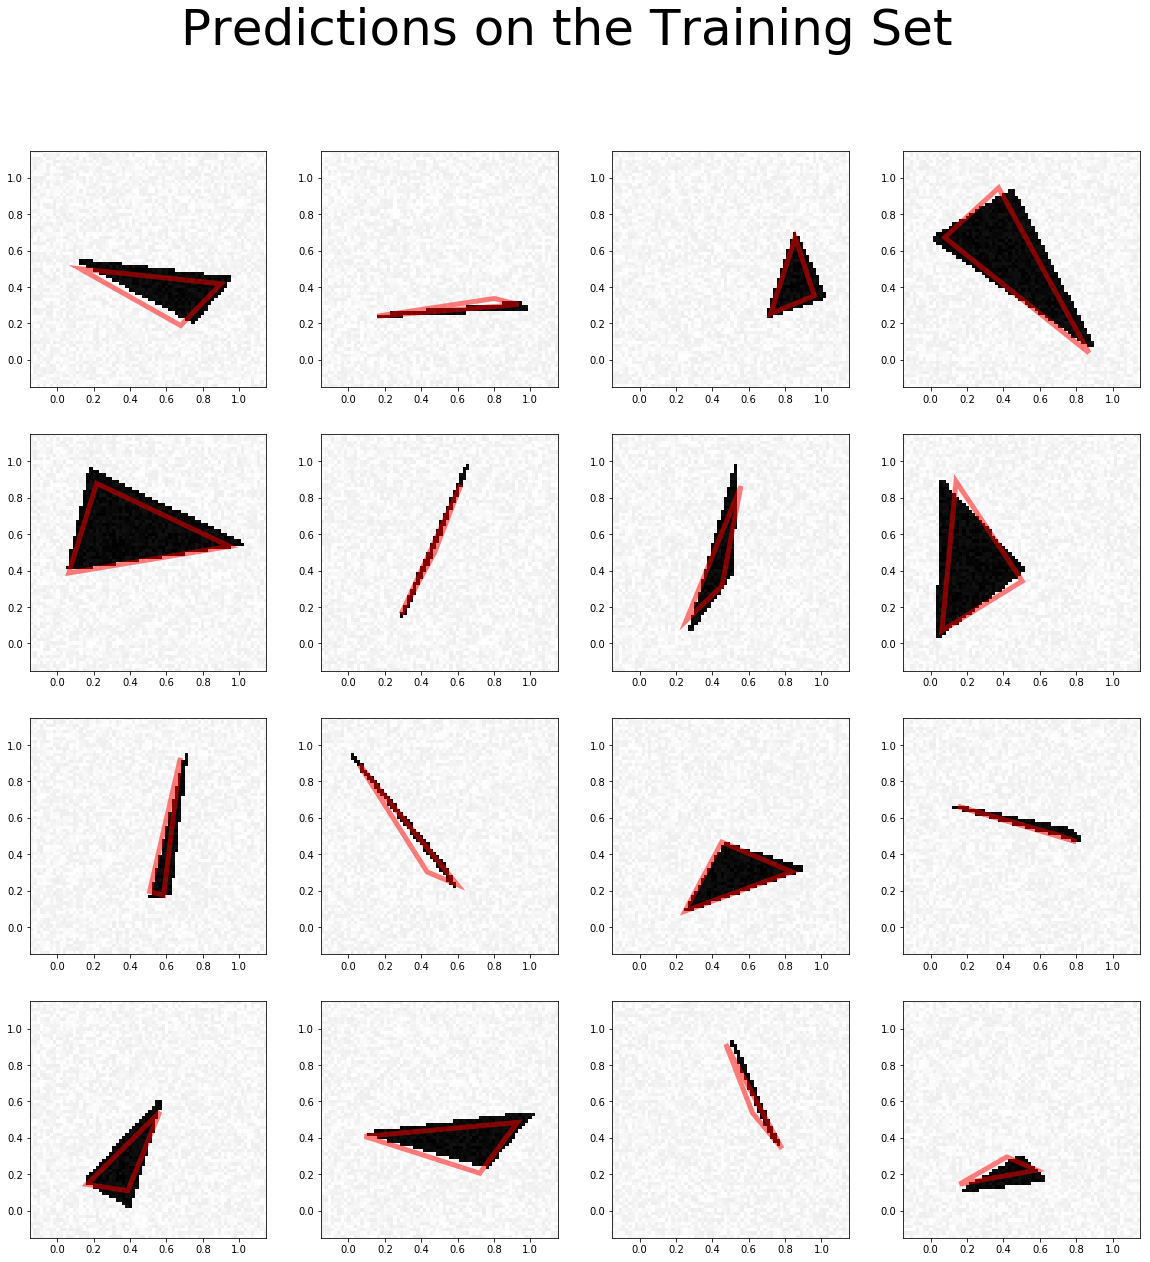

In [59]:
Y_train_predict=model.predict(X_train.reshape(1500,72,72,1))
fig, ax = plt.subplots(4,4, figsize=(20, 20))
plt.suptitle("Predictions on the Training Set", fontsize=50)
for i in range(0,16):
    x = X_train[i]
    y = Y_train_predict[i]
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax[i//4,i%4].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
plt.show()

This time, the predicted vertices in the training set are more accurate.

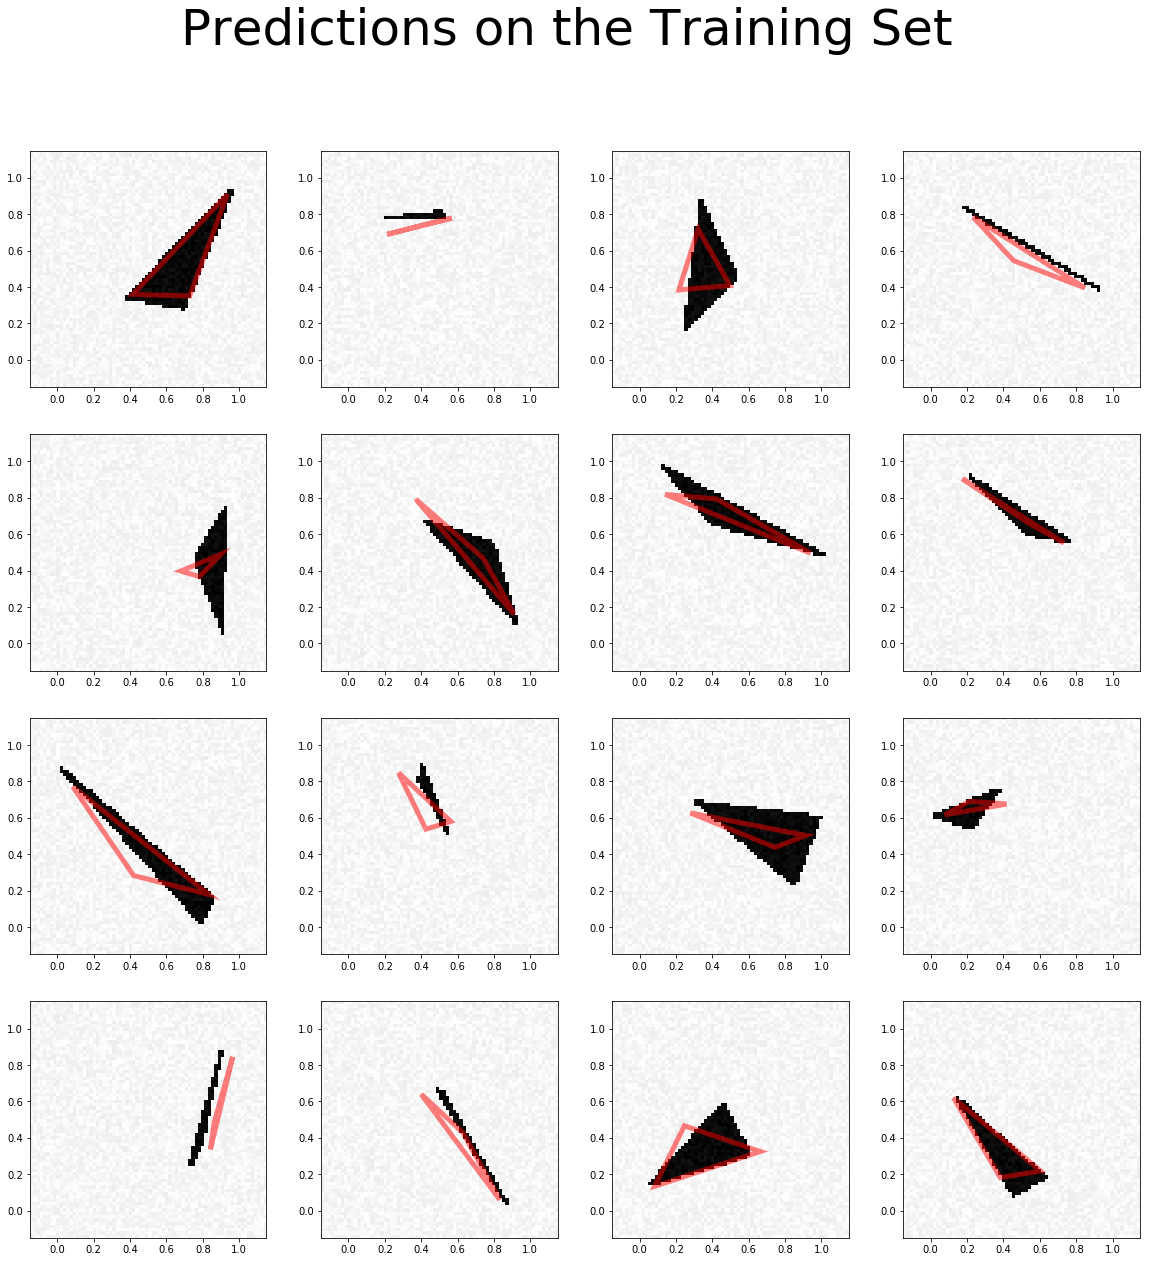

In [60]:
Y_test_predict=model.predict(X_test.reshape(300,72,72,1))
fig, ax = plt.subplots(4,4, figsize=(20, 20))
plt.suptitle("Predictions on the Training Set", fontsize=50)
for i in range(0,16):
    x = X_test[i]
    y = Y_test_predict[i]
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax[i//4,i%4].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
plt.show()

The vertices predicted for the test set are more accurate than before as well, but not as good as on the training set.

# Image Denoising


We implement a hourglass network for denoising, and train it to predict a noise-free image given a noisy image as an input.

We first modify the generating functions to get pairs of images, one having a random noise amplitude, and the second the same content without the noise

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_noise(figsize, U, V):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off') 
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    #imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    #imdata = (imdata + np.multiply(np.random.randint(0,256,imdata.size),np.random.random(imdata.size)))/2
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    noise = np.random.randint(0,255)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_pair(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing_noise(figsize, U, V), generate_a_drawing(figsize, U, V, 0.0)]


def generate_a_disk_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing_noise(figsize, U, V), generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_triangle_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return [generate_a_drawing_noise(figsize, U, V), generate_a_drawing(figsize, U, V, 0.0)]

In [62]:
def generate_dataset_denoising(nb_samples, noise = 50, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle_pair()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_pair(noise, free_location)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_pair(noise, free_location)
        else:
            [X[i], Y[i]] = generate_a_triangle_pair(noise, free_location)
    return [X, Y]

In [63]:
[X_train, Y_train] = generate_dataset_denoising(300)
X_train = X_train.reshape(X_train.shape[0],72,72,1)
Y_train = Y_train.reshape(Y_train.shape[0],72,72,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


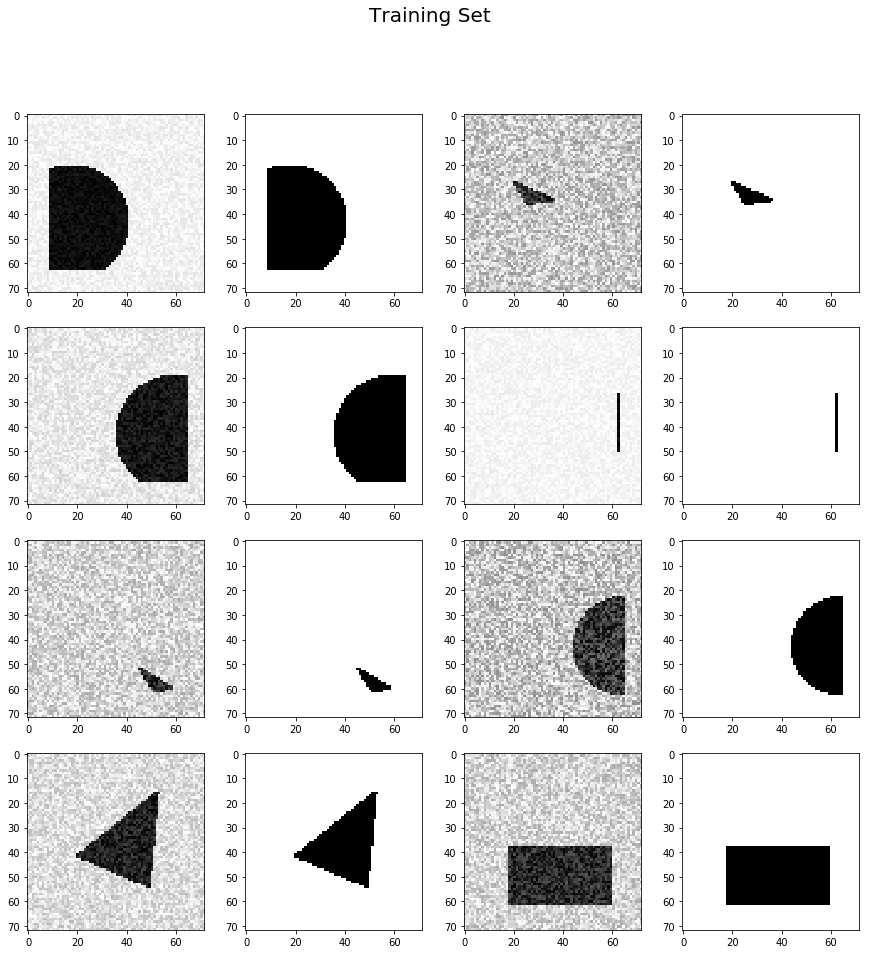

In [64]:
plt.figure(figsize=(15,15))
plt.suptitle("Training Set", fontsize=20)
for i in range(0,8):
    plt.subplot(4,4,2*i+1)
    plt.imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(4,4,2*i+2)
    plt.imshow(Y_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [65]:
def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 50)
    return [X_test, Y_test]
X_test, Y_test = generate_test_set_denoising()
X_test = X_test.reshape(X_test.shape[0],72,72,1)
Y_test = Y_test.reshape(Y_test.shape[0],72,72,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


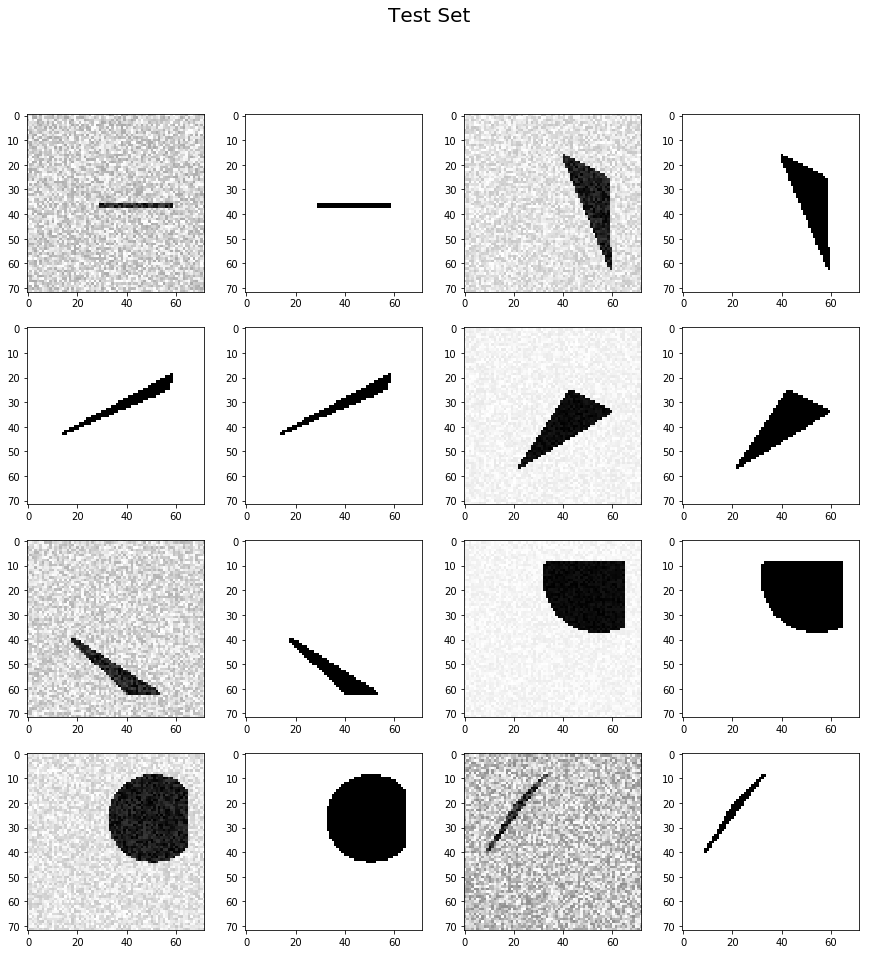

In [66]:
plt.figure(figsize=(15,15))
plt.suptitle("Test Set", fontsize=20)
for i in range(0,8):
    plt.subplot(4,4,2*i+1)
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(4,4,2*i+2)
    plt.imshow(Y_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [67]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

autoencoder = Sequential()
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(72,72,1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

We use a hourglass network with 2 convolution layers et 2 MaxPooling/UpSampling layers in each side.  
We binarize the images to predict values of 0 or 1 on each pixel. Therefore, we use a sigmoid function as our last activation function, and the binary-crossentropy as the loss function.

In [68]:
X_norm = X_train/255
Y_norm = Y_train/255
X_test_norm = X_test/255
Y_test_norm = Y_test/255
history = autoencoder.fit(X_norm, Y_norm,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_norm, Y_test_norm),
                verbose = 0)
print('trained')

trained


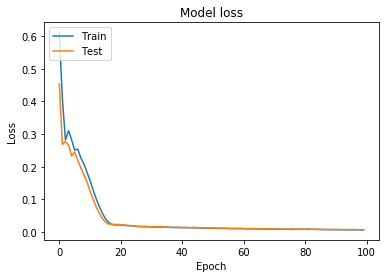

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [70]:
autoencoder.evaluate(x=X_test_norm, y=Y_test_norm)

300/300 [==============================] - 1s 4ms/step


0.007468654370556275

In [71]:
Y_predict_norm=autoencoder.predict(X_test_norm)

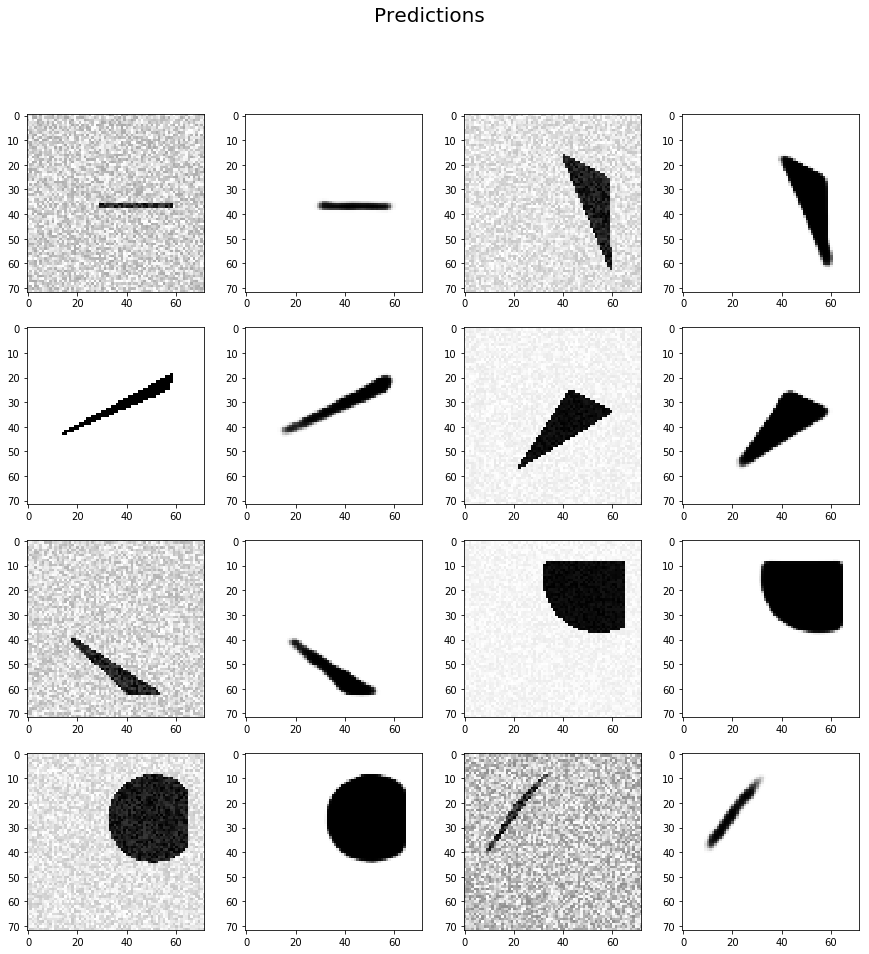

In [72]:
plt.figure(figsize=(15,15))
plt.suptitle("Predictions", fontsize=20)
for i in range(0,8):
    plt.subplot(4,4,2*i+1)
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(4,4,2*i+2)
    plt.imshow((Y_predict_norm[i]*255).reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

The denoising works well and generalizes from the training set to the validation set but the images predicted are a little blurred.